# Creating Prediction Model

We will be creating multiple linear regression models that will try and predict housing prices based on the features in our cleaned datasets. The models will be evaluated based on the root mean squared error (RMSE) of their predictions against the validation set. Once the best production model is found, the final model will then be retrained using the entire training dataset then its test set predictions will be submitted to Kaggle to determine the actual test score.

## Contents:
- [Finding Production Model](#Finding-Production-Model)
- [Submission](#Submission)
- [Conclusions](#Conclusions)

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics

%matplotlib inline

## Null Regression

First, we will be creating a null regression model using the train target mean as the predicted value. This is the most basic form of prediction we can perform and will serve as the baseline for our model evaluation, i.e. any model we create **must** beat this score.

In [2]:
test = pd.read_csv('../datasets/test.csv')
full_train = pd.read_csv('../datasets/full_train.csv')

In [3]:
# Creating dataframe with null regression predictions
null_regression = pd.DataFrame({
    'Id': [],
    'SalePrice': []
})

null_regression['Id'] = test['Id']
null_regression['SalePrice'] = full_train['SalePrice'].mean()

In [4]:
# Exporting .csv file for submission to Kaggle
null_regression.to_csv('../datasets/null_regression_submission.csv', index=False)

Submitting the null regression predictions to Kaggle,

![null_regression_score](../images/null_regression_score.png "Null Regression Score")

## Model Preparation

First, we will separate the features matrix `X` from our target vector `y` in the cleaned datasets.

In [5]:
# Import cleaned datasets
X_test = pd.read_csv('../datasets/test_cleaned.csv')
train = pd.read_csv('../datasets/partial_train_cleaned.csv')
val = pd.read_csv('../datasets/validation_cleaned.csv')
full_train = pd.read_csv('../datasets/full_train_cleaned.csv')

In [6]:
X_train = train.drop(columns='saleprice')
X_val = val.drop(columns='saleprice')
y_train = train['saleprice']
y_val = val['saleprice']
X_full_train = full_train.drop(columns='saleprice')
y_full_train = full_train['saleprice']

For this dataset, we will be testing 3 different types of models:
1. Linear Regression with no penalty
2. Ridge Regression (l2 penalty)
3. Lasso Regression (l1 penalty)

## Full Feature Models

First, we will try creating models using all 187 features in our dataset.

### Linear Regression

In [7]:
# Instantiate
lr_full = LinearRegression()

In [8]:
# Cross validation
np.abs(cross_val_score(lr_full, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

1896032143655874.5

In [9]:
# Evaluation against validation set
lr_full.fit(X_train, y_train)

np.sqrt(metrics.mean_squared_error(y_val, lr_full.predict(X_val)))

5132527322838277.0

### Ridge Regression

In [10]:
# Finding best alpha term
r_alphas = np.logspace(0, 5, 200)
ridge_cv_full = RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_cv_full.fit(X_train, y_train);

In [11]:
# Best alpha
ridge_cv_full.alpha_

6.368249944718588

In [12]:
# Instantiate
ridge_full = Ridge(alpha=ridge_cv_full.alpha_)

In [13]:
# Cross validation
np.abs(cross_val_score(ridge_full, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

23179.808296292555

In [14]:
# Evaluation against validation set
ridge_full.fit(X_train, y_train)

np.sqrt(metrics.mean_squared_error(y_val, ridge_full.predict(X_val)))

79571.38050358884

### Lasso Regression

In [15]:
# Finding best alpha term
lasso_cv_full = LassoCV(n_alphas=100)
lasso_cv_full.fit(X_train, y_train);

In [16]:
# Best alpha
lasso_cv_full.alpha_

63.65880001118351

In [17]:
# Instantiate
lasso_full = Lasso(alpha=lasso_cv_full.alpha_)

In [18]:
# Cross validation
np.abs(cross_val_score(lasso_full, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

23030.919504499307

In [19]:
# Evaluation against validation set
lasso_full.fit(X_train, y_train)

np.sqrt(metrics.mean_squared_error(y_val, lasso_full.predict(X_val)))

77536.92200803291

| Model      | No. of Features Input | Cross Val Score | Validation Score (RMSE) |
|------------|---------------------|-----------------|-------------------|
| null regression       | -                   | -               | 83689.75 (Kaggle) |
| lr_full    | 187                 |     1.9E+15     |     5.13E+15      |
| ridge_full | 187                 |     23179.81    |     79571.38      |
| lasso_full | 187                 |     23030.92    |     77536.92      |



# Finding Production Model

As seen above, the models using all the features did not perform very well. The basic linear regression model had ridiculously large predicted values which led to a huge RMSE score. The ridge & lasso models, while performing substantially better than the basic linear regression model, still had relatively high RMSE scores which were quite close to the null regression score.

The reason for these scores are clear - there are too many features included in the model. Many of these features could be considered 'noise', meaningless features that do not contribute to an accurate predictive value. In fact, including these features actually worsens the model performance, leading to a higher RMSE score. This is because these 'noisy' features can still be assigned non-zero coefficients as there will always be some sort of correlation with the target. Thus, the model will be overfitted and will not generalise well to new data.

## Feature Selection

The best way to resolve this is to cut down on the number of features included in the model. This will help to reduce the variance of the model, leading to better performance and lower RMSE scores. We will explore shortlisting features using two methods, and compare their results:
1. Filtering features based on correlation with the target variable
2. Recursive Feature Elimination

### Filtering Features

Here, we take a subset of the relevant features by plotting the Pearson correlation heatmap and selecting the features with the highest correlation with the target variable. The exact number to select is up for interpretation, but we will be going with the top 35 features for now.

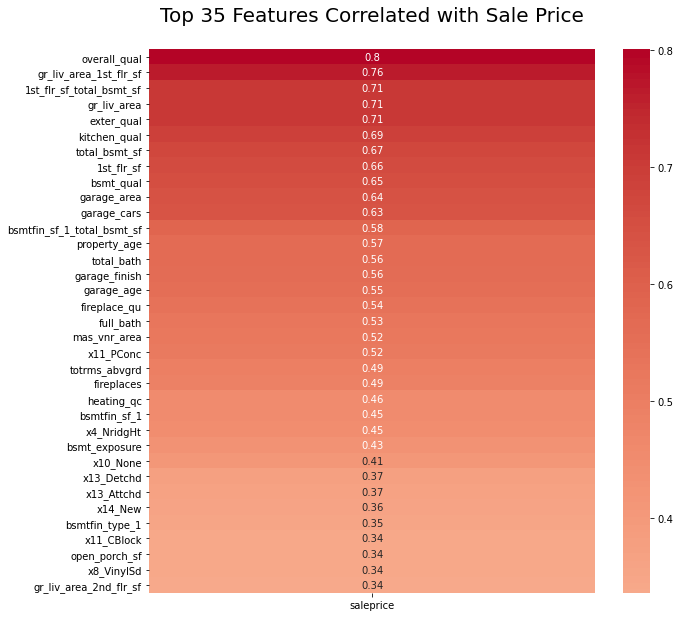

In [20]:
plt.figure(figsize=(10,10))

# Taking absolute value as the sign does not affect the feature's importance
corr_target = train.corr()[['saleprice']].abs().sort_values('saleprice',ascending=False)

sns.heatmap(
    corr_target[1:36],
    annot=True,
    cmap='coolwarm', 
    center=0
)

plt.title('Top 35 Features Correlated with Sale Price\n', fontsize=20);

In [21]:
# Creating list of top 35 correlated features
filtered_features = corr_target[1:36].index.tolist()

### Recursive Feature Elimination

Another strategy we can employ to reduce the number of features is Recursive Feature Elimination (RFE), which works by recursively removing features and rebuilding a particular model on the features that remain. It also gives each feature a ranking based on their coefficient and continues until it hits a specified target. Similar to before, we will be trying to find the top 35 features using each model.

#### Linear Regression

In [22]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=35)

# Fitting to training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)

# Tabulating RFE results
rfe_results = [np.array(X_train.columns), rfe.ranking_]
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df.columns = ['Feature', 'RFE Ranking']

# Top 35 features
rfe_lr_features = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()

#### Ridge Regression

In [23]:
# Using similar alpha for ease of computation
model = Ridge(alpha=ridge_cv_full.alpha_)
rfe = RFE(model, n_features_to_select=35)

# Fitting to training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)

# Tabulating RFE results
rfe_results = [np.array(X_train.columns), rfe.ranking_]
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df.columns = ['Feature', 'RFE Ranking']

# Top 35 features
rfe_ridge_features = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()

#### Lasso Regression

In [24]:
# Using similar alpha for ease of computation
model = Lasso(alpha=lasso_cv_full.alpha_, max_iter=10000)
rfe = RFE(model, n_features_to_select=35)

# Fitting to training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)

# Tabulating RFE results
rfe_results = [np.array(X_train.columns), rfe.ranking_]
rfe_results_df = pd.DataFrame(rfe_results).T
rfe_results_df.columns = ['Feature', 'RFE Ranking']

# Top 35 features
rfe_lasso_features = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()

### Testing Features Selected

We now have 4 different sets of features from our various methods of feature elimination. We will compare their results for each of the regression models.

In [25]:
reduced_features = [filtered_features, rfe_lr_features, rfe_ridge_features, rfe_lasso_features]

In [26]:
# Linear Regression
for i, feature_list in enumerate(reduced_features):
    X_train_less = X_train[feature_list]
    lr_reduced = LinearRegression()
    cvs = np.abs(cross_val_score(lr_reduced, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lr_reduced.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lr_reduced.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

0
CVS: 26040.470574884974
Validation Score: 87603.1348576358

1
CVS: 43022.66261807685
Validation Score: 55774.40875465982

2
CVS: 24163.223269962036
Validation Score: 78392.05855815268

3
CVS: 22914.137375249993
Validation Score: 78911.58832602185



In [27]:
# Ridge Regression
for i, feature_list in enumerate(reduced_features):
    X_train_less = X_train[feature_list]
    r_alphas = np.logspace(0, 5, 200)
    ridge_cv_red = RidgeCV(alphas=r_alphas, store_cv_values=True)
    ridge_cv_red.fit(X_train_less, y_train)
    ridge_red = Ridge(alpha=ridge_cv_red.alpha_)
    cvs = np.abs(cross_val_score(ridge_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    ridge_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, ridge_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

0
CVS: 25995.600074963797
Validation Score: 84717.50240945362

1
CVS: 42790.002386615626
Validation Score: 55458.198381557995

2
CVS: 24125.743451986335
Validation Score: 78573.0127805681

3
CVS: 22948.29230388729
Validation Score: 78917.21577304168



In [28]:
# Lasso Regression
for i, feature_list in enumerate(reduced_features):
    X_train_less = X_train[feature_list]
    lasso_cv_red = LassoCV(n_alphas=100)
    lasso_cv_red.fit(X_train_less, y_train)
    lasso_red = Lasso(alpha=lasso_cv_red.alpha_)
    cvs = np.abs(cross_val_score(lasso_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lasso_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lasso_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

0
CVS: 26022.989003083985
Validation Score: 84099.84657457471

1
CVS: 42807.65332482317
Validation Score: 55290.5800072872

2
CVS: 24360.65554182548
Validation Score: 79196.55601377807

3
CVS: 23221.004421087564
Validation Score: 78289.30556672976



| Feature List      | No. of Features | LR CVS   | LR Validation Score | Ridge CVS | Ridge Validation Score | Lasso CVS | Lasso Validation Score |
|-------------------|-----------------|----------|---------------------|-----------|------------------------|-----------|------------------------|
| Filtered Features | 35              | 26040.47 | 87603.13            | 25995.6   | 84717.5                | 26022.99  | 84099.85               |
| RFE (LR)          | 35              | 43022.66 | 55774.41            | 42790     | 55458.2                | 42807.65  | 55290.58               |
| RFE (Ridge)       | 35              | 24163.22 | 78392.06            | 24125.74  | 78573.01               | 24360.66  | 79196.56               |
| RFE (Lasso)       | 35              | 22914.14 | 78911.59            | 22948.29  | 78917.22               | 23221     | 78289.31               |


As can be seen above, they generally performed similarly to each other, with the exception of linear regression RFE, which had surprisingly high cross validation scores and low validation scores against the validation set. However, upon inspecting the feature list further, it appears that the RFE (LR) method produced a feature list which was largly made up of nominal features.

This method would have too high a bias despite the lower variance, and may not be accurate enough for our purposes as the features in the list are not very descriptive as a whole. Overall, the Lasso RFE method seems to produce the best results.

### Combining RFE & Filter

Perhaps a better method would be to reduce the number of features by filtering based on correlation to sale price, then applying RFE to select the best features.

In [29]:
# Filtering by correlation with saleprice
corr_target_comb = train.corr()[['saleprice']].abs().sort_values('saleprice',ascending=False)
filtered_features_comb = corr_target[1:76].index.tolist()

In [30]:
# Use Lasso RFE, test with different numbers of features
feature_list_dict = {}
for no_of_features in [20, 25, 30, 35]:
    X_train_comb = X_train[filtered_features_comb]
    lasso_cv_comb = LassoCV(n_alphas=100)
    lasso_cv_comb.fit(X_train_comb, y_train)
    model = Lasso(alpha=lasso_cv_comb.alpha_, max_iter=10000)
    rfe = RFE(model, n_features_to_select=no_of_features)

    # Fitting to training data
    X_train_rfe = rfe.fit_transform(X_train_comb, y_train)
    model.fit(X_train_rfe, y_train)

    # Tabulating RFE results
    rfe_results = [np.array(X_train_comb.columns), rfe.ranking_]
    rfe_results_df = pd.DataFrame(rfe_results).T
    rfe_results_df.columns = ['Feature', 'RFE Ranking']

    # Top features
    rfe_lasso_features_comb = rfe_results_df.loc[rfe_results_df['RFE Ranking'] == 1, 'Feature'].tolist()
    feature_list_dict[no_of_features] = rfe_lasso_features_comb

Testing each list of features:

In [31]:
# Linear Regression
for i, feature_list in feature_list_dict.items():
    X_train_less = X_train[feature_list]
    lr_reduced = LinearRegression()
    cvs = np.abs(cross_val_score(lr_reduced, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lr_reduced.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lr_reduced.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

20
CVS: 25623.79241757507
Validation Score: 87152.85837576163

25
CVS: 25150.088238894397
Validation Score: 88179.54531716209

30
CVS: 24776.496810233562
Validation Score: 85453.67210801247

35
CVS: 24496.365882088106
Validation Score: 80448.75965286451



In [32]:
# Ridge Regression
for i, feature_list in feature_list_dict.items():
    X_train_less = X_train[feature_list]
    r_alphas = np.logspace(0, 5, 200)
    ridge_cv_red = RidgeCV(alphas=r_alphas, store_cv_values=True)
    ridge_cv_red.fit(X_train_less, y_train)
    ridge_red = Ridge(alpha=ridge_cv_red.alpha_)
    cvs = np.abs(cross_val_score(ridge_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    ridge_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, ridge_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

20
CVS: 25615.53141260896
Validation Score: 86218.13406576746

25
CVS: 25129.715077353016
Validation Score: 87302.82221133047

30
CVS: 24750.55070556042
Validation Score: 84405.0115851766

35
CVS: 24460.35114577307
Validation Score: 79223.22122558298



In [33]:
# Lasso Regression
for i, feature_list in feature_list_dict.items():
    X_train_less = X_train[feature_list]
    lasso_cv_red = LassoCV(n_alphas=100)
    lasso_cv_red.fit(X_train_less, y_train)
    lasso_red = Lasso(alpha=lasso_cv_red.alpha_)
    cvs = np.abs(cross_val_score(lasso_red, X_train_less, y_train, scoring='neg_root_mean_squared_error').mean())
    lasso_red.fit(X_train_less, y_train)
    val_score = np.sqrt(metrics.mean_squared_error(y_val, lasso_red.predict(X_val[feature_list])))
    print(i)
    print(f'CVS: {cvs}')
    print(f'Validation Score: {val_score}')
    print()

20
CVS: 25672.330380290656
Validation Score: 85773.27177083187

25
CVS: 25227.762202298396
Validation Score: 86079.81945662334

30
CVS: 24861.41324810941
Validation Score: 83118.73818533286

35
CVS: 24600.17485912016
Validation Score: 78229.85930907184



| No. of Features | LR CVS   | LR Validation Score | Ridge CVS | Ridge Validation Score | Lasso CVS | Lasso Validation Score |
|-----------------|----------|---------------------|-----------|------------------------|-----------|------------------------|
| 20              | 25623.79 | 87152.86            | 25615.53  | 86218.1341             | 25672.33  | 85773.27               |
| 25              | 25150.09 | 88179.55            | 25129.72  | 87302.8222             | 25227.76  | 86079.82               |
| 30              | 24776.5  | 85453.67            | 24750.55  | 84405.0116             | 24861.41  | 83118.74               |
| 35              | 24496.37 | 80448.76            | 24460.35  | 79223.2212             | 24600.17  | 78229.86               |


Based on the comparison, it appears that the more features there were, the better the predictions. However, we should be careful not to include too many features into the model as it could introduce noise and affect the actual predictions. Additionally, limiting the number of features to 35 would produce an easily interpretable model, which home-owners and home-buyers would be appreciative of.

In [34]:
final_feature_list = feature_list_dict[35]

# Submission


Kaggle expects submissions in a specific format. We will re-train the model on the entire training dataset (including the validation set) in order for the model to have more information and perform better, then format the submission file.

In [35]:
# Retrain model on entire training dataset
X_final = X_full_train[final_feature_list]

# Finding best alpha
r_alphas = np.logspace(0, 5, 200)
lasso_cv_final = LassoCV(n_alphas=100)
lasso_cv_final.fit(X_final, y_full_train)

# Creating final model
model_final = Lasso(alpha=lasso_cv_final.alpha_)
model_final.fit(X_final, y_full_train)

# Creating predictions on test set
test_preds = model_final.predict(X_test[final_feature_list])

In [36]:
# Creating dataframe with final predicted values
final_sub = pd.DataFrame({
    'Id': [],
    'SalePrice': []
})

final_sub['Id'] = test['Id']
final_sub['SalePrice'] = test_preds

In [37]:
# Checking format & no. of rows
final_sub

,Id,SalePrice
0,2658,124333.172213
1,2718,174815.740490
2,2414,232389.627236
3,1989,113903.623608
4,625,166689.162981
...,...,...
874,1662,188297.644173
875,1234,217557.506734
876,1373,132244.761327
877,1672,112360.247415


In [38]:
# Export for submission
final_sub.to_csv('../datasets/final_submission.csv', index=False)

![final_rmse_score](../images/final_rmse_score.png "Final RMSE Score")

# Conclusions

Our model returned a pretty decent RMSE score of just over 23,000. As compared to the null regression (83689), it shows that our model would quite a fair bit of value to home-owners who would want to predict the sale price of their homes. This resolves our problem statement, **How can we best predict the sale price of a house using a linear regression model?**

## Interpreting Coefficients

Feature coefficients can be simply interpreted as `Bx` in the linear regression equation: `Y = B0 + B1X1 + ... + BxXx + e`

`B0` represents the intercept while `Bx` represents the slope parameter. For instance,

In [39]:
final_feature_list[0]

'overall_qual'

In [40]:
model_final.coef_[0]

17232.647437522442

In [41]:
model_final.intercept_

167665.7261968751

Suggests that `overall_qual` impact on our model is as follows:
`sale_price` = 167665.73 + 17232.65(`overall_qual`)

Meaning to say, a one unit increase in overall quality of the house would relate to a predicted increase in sale price of $17,232.

## Recommendations

We can interpret the model further by finding features that appear to add the most value to a home, which would be useful information to home owners.

In [42]:
coefs = pd.DataFrame([final_feature_list, model_final.coef_]).T

In [43]:
coefs.columns = ['feature', 'Coefficient']

In [44]:
coefs.sort_values(by='Coefficient', ascending=False).head(8)

,feature,Coefficient
23,x4_StoneBr,25104.6
17,gr_liv_area_2nd_flr_sf,22358.8
12,x4_NridgHt,21036.6
2,1st_flr_sf_total_bsmt_sf,19610.2
15,x14_New,19360.9
0,overall_qual,17232.6
1,gr_liv_area_1st_flr_sf,13022.5
31,x2_HLS,12754


The features with the highest coefficients include physical neighbourhood locations (`StoneBr` and `NrigHt`), which suggests that these are exclusive neighbourhoods with high property values. There are also 3 interaction features relating to the size of the house, which explains that the bigger the house, the higher its value. The `overall_qual` of the house is also an important factor in increasing the sale price of the house.

In [45]:
coefs.sort_values(by='Coefficient', ascending=True).head(8)

,feature,Coefficient
9,property_age,-8162.77
21,x1_RM,-7769.59
29,x8_Wd Sdng,-6632.38
3,gr_liv_area,-6558.28
28,2nd_flr_sf,-4720.94
6,total_bsmt_sf,-4603.68
16,x11_CBlock,-4036.95
30,bsmt_unf_sf,-2862.24


Conversely, features like an aging house, wooden sidings and a large unfinished basement could lead to a lower sale price.